At this post we will talk about the analysis of time series data with Trend and Seasonal components. An Econometric approach will be followed to model the statistical properties of the data. The business objective here is forecasting. We attempted to explain various concepts invloved in time series modelling, such as time series componenets, serial correlation, model fitting, metrics, etc. We will use SARIMAX model provided by statsmodels library to model both, seasonality and trend in the data. SARIMA (Seasonal ARIMA) is capable of modelling seasonality and trend together, unlike ARIMA which can only model trend.
The post will cover the below sections:
1. What is time series data?
2. Introducing the data
3. Seasonal decomposition and Time series components: Trend, Seasonality, Cycles, Residuals
3. Stationarity in time series data and why it is important
4. Autocorrelation and partial autocorrelation
5. How to identify Seasonality
6. 
7. Data transformation: Log transformation and differencing
8. Model fitting
9. Metrics and model selection
10. Forecasting



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 1. What is time series data?
Time series data is a sequence of data points measured over time intervals. In other words, data is function of time f(t) = y
Data points can be measured hourly, daily, weekly, monthly, quarterly, yearly and also with smaller or larger time scales such as seconds or decades. 

# EDA

## 2.Introducing the data
The data we are using in this article is monthly home sales index for 20 major US cities between years 2000 and 2019. (https://fred.stlouisfed.org/series/SPCS20RPSNSA) You can freely download many different economic time series data representing US economy from this source. You may see 2 different versions of the same data, seasonally-adjusted and non seasonally-adjusted. Seasonally adjusted data is time series data without seasonal componenet. The version used at this post is not seasonally adjusted as we want to model the seasonality as well as trend. You may ask why people want to use seasonally adjusted data in the industry. Well, sometimes businesses may want to know the true effect of economic events on a particual data, which may overlap with a season. In that case, seasonality may hide or underestimate/overestimate the effect of an economic event. For instance: Heating oil producers may want to study the impact of declining petrol prices on heating oil prices. However, heating oil prices are increasing in winter, which is surprising as heating oil is just one of the sub-products of petrol. The decrease in petrol prices should be reflected on decrease in heating oil prices. However, in winter there is a big demand for heating, specially if winter is colder than usual. By removing the seasonal effect from the time series data, you may see that actually heating oil price follows a decreasing trend. The slight increase in the price was the seasonal effect. In Section @@, we will talk about seasonal decomposition in more detail.  

In [2]:
original_data = pd.read_csv(filepath_or_buffer='SPCS20RPSNSA.csv', index_col='DATE', parse_dates=True)
original_data.head()

,SPCS20RPSNSA
DATE,
2000-01-01,76273
2000-02-01,70994
2000-03-01,72795
2000-04-01,79561
2000-05-01,92584


In [3]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 229 entries, 2000-01-01 to 2019-01-01
Data columns (total 1 columns):
SPCS20RPSNSA    229 non-null int64
dtypes: int64(1)
memory usage: 3.6 KB


In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plot_data_properties(...)  function plots time series data as well as autocorrelation and partial autocorrelation graphs and histogram of data points.  

In [5]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    '''
    Summary:
    -------
    Plots various plots, including time series, autocorrelation,
    partial autocorrelation and distribution plots of data.
    
    Parameters:
    ----------
    ts_plot_name(String): The name of the time series plot
    data(pd.Dataframe, pd.Series, array): Time Series Data
    
    Returns:
    --------
    None
    
    '''
    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Sales')
    plt.xlabel('Year')
    fig, axes = plt.subplots(1,3,squeeze=False)
    fig.set_size_inches(16,4)
    plot_acf(data, ax=axes[0,0], lags=48);
    plot_pacf(data, ax=axes[0,1], lags=48);
    sns.distplot(data, ax=axes[0,2])
    axes[0,2].set_title("Probability Distribution")

## Stationarity in time series data and why it is important
@Talk about serial correlation and stationary data should look random and follow N(0,1)@
If we look at the time series plot of the data we can observe an increasing trend in 2000-2006, a decreasing trend in home sales starting from 2007 till 2012 due to big financial crisis and increasing trend again till 2019. We can also absorve seasonality in the data as usually the housing market is not active at the beginning of a year and sales usually go high in mid-year and again sales getting lower by the end of the year. Seems like spring and summer are the good seasons for American housing market.

When we have trend and/or seasonality in a time series data we call it non-staionary. Why are we calling the data non-stationary and why are we scared of this phenomenon? Stationarity means the statistical properties of data, such as mean, variance, standard deviation remain constant over time. Why do we want the statistical properties to remain same over time? Well, because we make statistical assumptions (a good example could be OLS assumptions) about the data in due course of model building and the model will only be capable of performing under those assumptions. When the statistical properties of the data changes, the model is no longer capable of respresenting the true nature of data as data properties have been changed. That's why our forecasting/prediction results will no longer will be valid. Changing mean/variance will require us to fit another model and this model may be valid for a short period of time and again we have to dispose it and fit another model. See, how inefficient and unreliable this process looks like. 

We have to make time series data staionary before fitting a model. We can make time series stationary by transforming the data. Usually, differencing is used to make the data stationary. We will talk about it in Section 7, below.

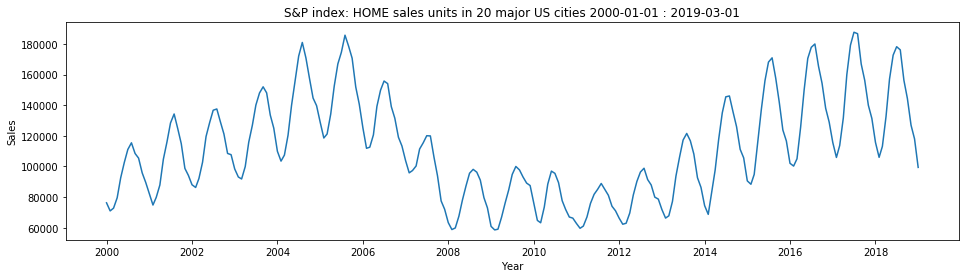

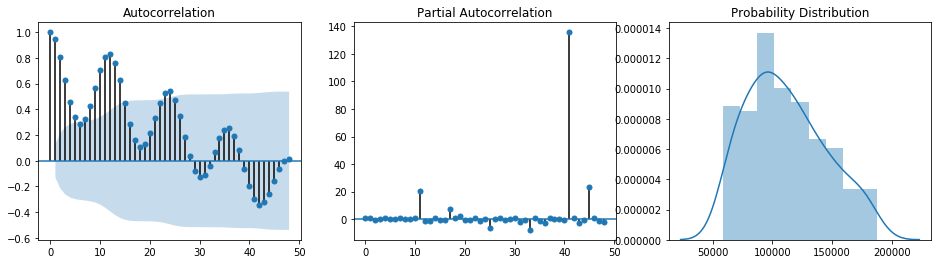

In [6]:
plot_data_properties(original_data, 'S&P index: HOME sales units in 20 major US cities 2000-01-01 : 2019-03-01');

So, how can we test whether a time series data is staionary or not. The first is just eyeballing the time series plot and identify trend or seasonality, secondly you may divide the data into 3 different sets and calculate mean and variance for each set and confirm whether mean and variance for each set is substantially different or not. Third option is to use one of the statistical tests provided in statsmodels library. Augmented Dickey Fuller test is the most popular amongst others, where null hypohtesis H_0 = data is not stationary. ADF test result provides test statistic and P value. P value >= 0.05 means the data is not stationary, otherwise we reject the null hypothesis and say data is stationary. I assume you know what hypothesis testing is and what P value means. If you are not quite familiar with these terms, then look at the p value and if it is smaller than 0.05 (p value < 0.05) then data is stationary, if p value >= 0.05 data is not stationary. 

The original data is not stationary as it has trend and seasonality components. 
ADF test confirms non-stationarity of the data.

You can also look at Autocorrelation plot, above and observe autocorrelation at lags=12 and 24 are significant. Autocorrelation plot shows the correlation of time series data with its own lagged values. For example, autocorrelation at lag=1, shows the correlation of y_t and y_t-1. At lag=2 corr(y_t, y_t-2). At lag=12 corr(y_t, y_t-12). So, at this plot every data point at time t has high correlation with at time t-12, which means a data point is correlated with the data at this month last year. You can notice high correlation from the example scatterplots below. Blue shaded area at autocorrelation plot shows significance level. So, correlation coefficients within the shaded show weak correlation at those lags, so we don't consider them significant.
The partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values. PACF removes the correlation contribution of other lags and gives the pure correlation between two lags without the effect of others. We use ACF and PACF to choose a correct order for AR(p) and MA(q) values of ARIMA model. For AR order p look at PACF plot and choose lag value which has significant correlation factor before correlations get insignificant. For MA order q look at ACF plot and do the same. Don't forget you should only get these values from the acf and pacf plots of stationary time series. So, in our case we have to make the data stationary.

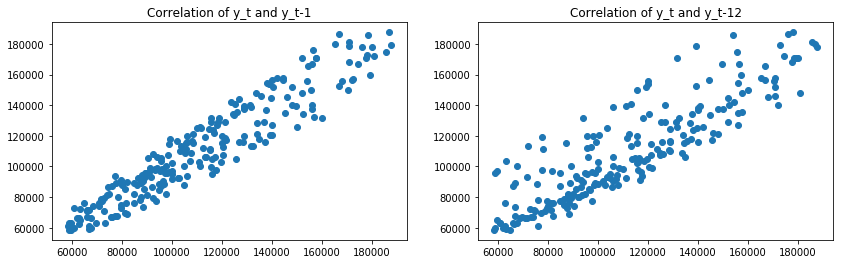

In [7]:
fig, axes = plt.subplots(1,2, squeeze=False);
fig.set_size_inches(14,4);
axes[0,0].scatter(x=original_data[1:], y=original_data.shift(1)[1:]);
axes[0,1].scatter(x=original_data[12:], y=original_data.shift(12)[12:]);
axes[0,0].set_title('Correlation of y_t and y_t-1');
axes[0,1].set_title('Correlation of y_t and y_t-12');

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(data):
    '''
    Summary:
    -------
    Performs Adfuller test on given time series data to test stationarity.
    p_val >= 0.05 means the data is not stationary, otherwise (p_val < 0.05) it is stationary.
    
    Parameters:
    data(pd.Dataframe, pd.Series. np.array): Time series data to be tested
    
    Return:
    ------
    '''
    p_val=adfuller(data['SPCS20RPSNSA'])[1]
    if p_val >= 0.05:
        print("Time series data is not stationary. Adfuller test pvalue={}".format(p_val))
    else:
        print("Time series data is stationary. Adfuller test pvalue={}".format(p_val))

In [9]:
test_stationarity(original_data)

Time series data is not stationary. Adfuller test pvalue=0.0803366374517756


We split the original data to training and test data. Training data will contain
US home sales data from 2000 to 2008 and test data will contain data from 2018 to 2019. Don't forget that you cannot do random sampling 
as you were doing for cross-sectional data. We have to keep the temporal behavior (dependence on time) of time series data.

In [10]:
test_start_date = '2018-01-01'
training_data = original_data[:test_start_date]
test_data = original_data[test_start_date:]

## 3. Seasonal decomposition and Time series components: Trend, Seasonality, Cycles, Residuals
Time series data Y is composed of a combination of Trend, Cycles, Seasonality and Residuals. Obviously, you may come across with time series where it doesn't have a Trend, Cycles or Seasonality. So, it is your task to identify the componenets of Y.
Trend - long-term updward or downward movement. 
Cycle - periodic variation due to economic movements. It is different from seasonal variation. Cycle is the variation in autoregressive component of time series data. Cycles occur within longer time intervals such as every 6-10 years, whereas seasonal variation occurs in shorter time intervals. 
Seasonality - variation in data caused by seasonal effects. Ice cream sales are high in summer, heating oil sales are high in winter but low in summer.
Residuals - a componenet that is left after other components have been calculated and removed from time series data. It is randomly distributed. Follows ~ N(0,1)

Statsmodels library has a function called seasonal_decompose, which decomposes Y into Trend, Seasonality and Residuals. Although, it is a naive decomposition algorithm, in practice it is very intuitive and works well for time series data where T, S and R are obvious. Before explaining the below graphs I would like to talk about the interaction among these components. 
Time series data Y can take either an additive or a multiplicative form. In additive form time series Y is formed by the sum of time series components, namely, T,S,C,R:
Y = T + C + S + R

In multiplicative form time series Y is formed by the product of time series components:
Y = T * C * S * R

Your task will be to identify whether Y is multiplicative or additive first, in order to decompose the series correctly and build a right model. If you carefully look at the time series plot of Housing index you may notice that the seasonal variation (seasonality) gets smaller when the trend decreases (years 2008-2013) and gets bigger when the trend increases (years 2014-2019). This happens in multiplicative time series, where small value for trend T results in small S, because we multiply S by T. 
In additive time series you don't experience this phenomenon. 

We decompose time series data into Trend, Seasonal componenet and Residuals.
We use seasonal_decompose() function from statsmodels to decompose and plot the componenets. Don't be surprised if the function returns all 3 componenets even though you assume that they do not exist for a particular time series data. In reality these components are generated by a simple algorithm involving simple math, that's why the decomposition function cannot say a component doesn't exist, even though the calculated value is not significant. So, you will see these three components for any time series data. You have to know how to read the results and decide which model (ARIMA or SARIMA) to fit to the data.

In [11]:
def plot_seasonal_decompose(data, model):
    '''
    Summary:
    -------
    Plots trend, seasonality and residuals with bigger plot size=(10,2)
    
    Parameters:
    ----------
    data(pd.Dataframe, pd.Series): time series data
    
    Return:
    ------
    decomposition(obj): return value of statsmodels.tsa.seasonal.seasonal_decompose
    '''
    decomposition = seasonal_decompose(data,model=model)
    decomposition.trend.plot(figsize=(10,2), title='Trend');
    decomposition.seasonal.plot(figsize=(10,2), title='Seasonality');
    decomposition.resid.plot(figsize=(10,2), title='Residuals');
    return decomposition

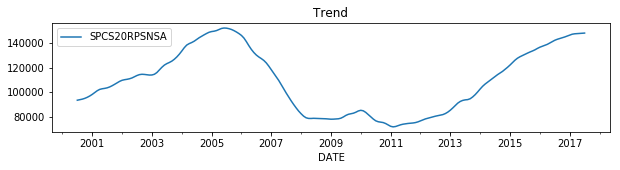

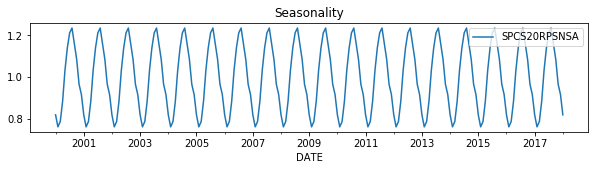

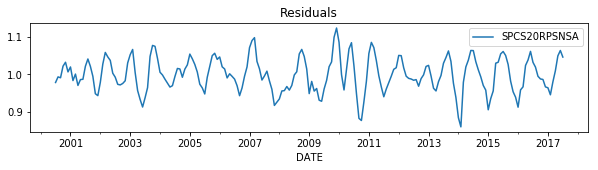

In [12]:
decomposition = plot_seasonal_decompose(training_data, 'multiplicative')

Trend is just a moving average window 12. The below plot is very similar to what seasonal_decompose function Trend looks like.

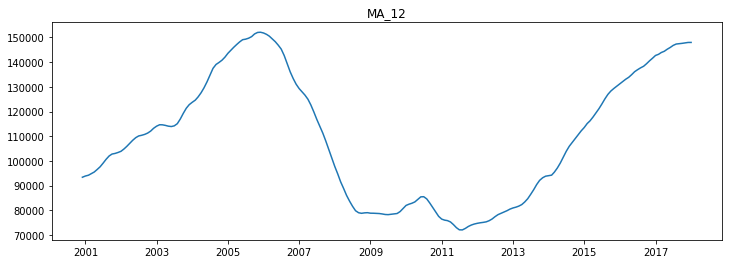

In [13]:
#Trend is moving avg
ma_12 = training_data.rolling(window=12).mean()
plt.figure(figsize=(12,4));
plt.plot(ma_12);
plt.title('MA_12');

Remember multiplicative model? Y = T * C * S * R 
Dividing Y by Trend may give you C*S*R and we asssume that Residuals is too small for this data as the time series plot looks smooth. In terms of cycles, there is a cycle but we hope it won't affect too much. The below plot shows
S = Y / T
Red marked y value y=1.2 means in July-2000 there was 20% more sales. In other words, June has a seasonal effect of 20% or 1.2 *  T.
Green marked y value y=0.8 in Feb-2003 there was 20% less sales. February has a negative seasonal effect on data. So, for some time series data you may see seasonal effect is very small i.e y=0.0001. It shows a very small seasonal effect, which shouldn't even be considered as a seasonal effect.  

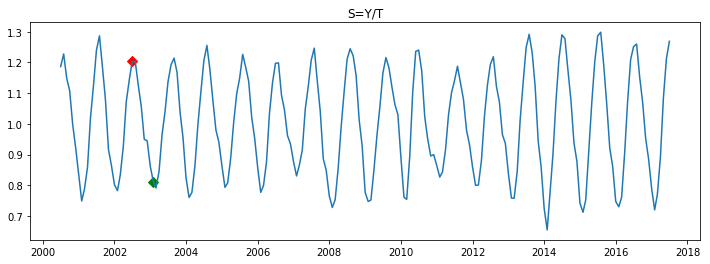

In [14]:
seasonal_component = training_data /decomposition.trend
plt.figure(figsize=(12,4))
plt.plot(seasonal_component);
plt.scatter(x='2002-07-01', y=seasonal_component.loc['2002-07-01'], marker='D', s=50, color='r');
plt.scatter(x='2003-02-01', y=seasonal_component.loc['2003-02-01'], marker='D', s=50, color='g');
plt.title('S=Y/T');

Resdiuals can be computed as R = Y/(S*T)

Text(0.5,1,'R = Y / (S*T)')

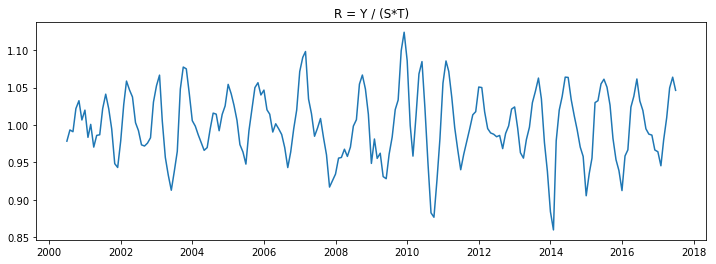

In [15]:
#R = Y/(S*T)
residual_component= training_data/(decomposition.trend*decomposition.seasonal)
plt.figure(figsize=(12,4))
plt.plot(residual_component);
plt.title('R = Y / (S*T)')

There are some other ways to observe seasonality. For example, in the below graph I have plotted home sales for each year.
And as you can see every year follows pretty much the same pattern with slight difference. House sales are high in summer, lower in winter months. 

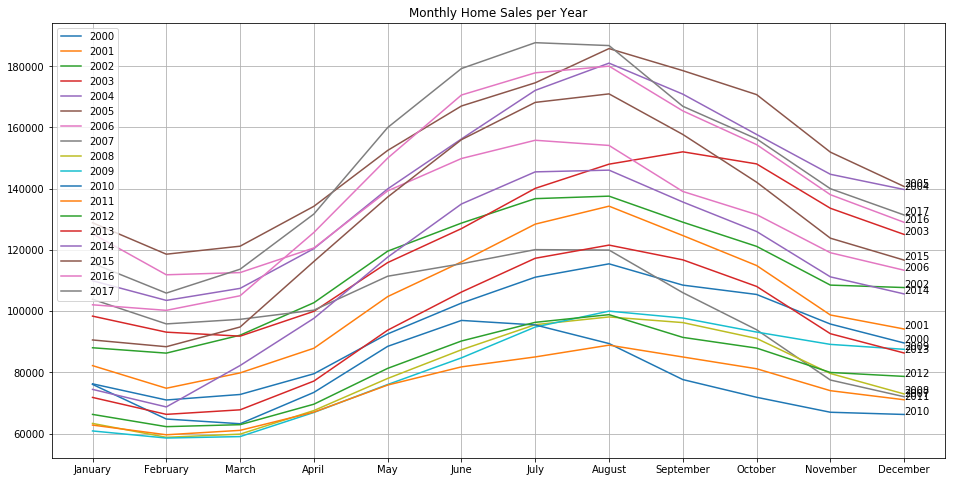

In [16]:
plt.figure(figsize=(16,8))
plt.grid(which='both')
years = int(np.round(len(training_data)/12))
for i in range(years):
    index = training_data.index[i*12:(i+1)*12]
    plt.plot(training_data.index[:12].month_name(),training_data.loc[index].values);
    plt.text(y=training_data.loc[index].values[11], x=11, s=training_data.index.year.unique()[i]);
plt.legend(training_data.index.year.unique(), loc=0);
plt.title('Monthly Home Sales per Year');

# LOG Transformed

## 7. Data transformation: Log transformation and differencing

Home sales index data can be formulated as a multiplicative model where Y= T*S*R. I am ignoring Cycles, as it is not actually present in this data. (S)ARIMA models are linear models, like Linear Regression. We can not fit a linear model SARIMA to data generated by a process Y = T*S*R. We have to make Y linear before fitting a linear model. As you are aware of from math Log(a*b) = log(a) + log(b). We have to logtransform the data to make it linear.
log(Y) = log(T) + log(S) + log(R).
Log transformation makes data linear and smoother. Sometimes, log transformation on itself can make data stationary, which is not the case here. We have to take 1st order of Integration (differencing) to remove trend and take 12th order integration to remove seasonality from the data. Then the series will be stationary.

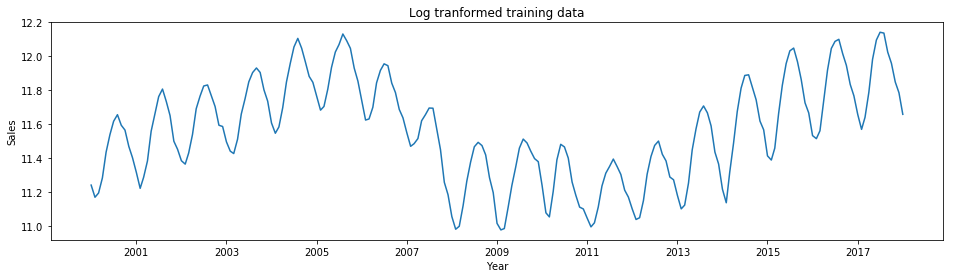

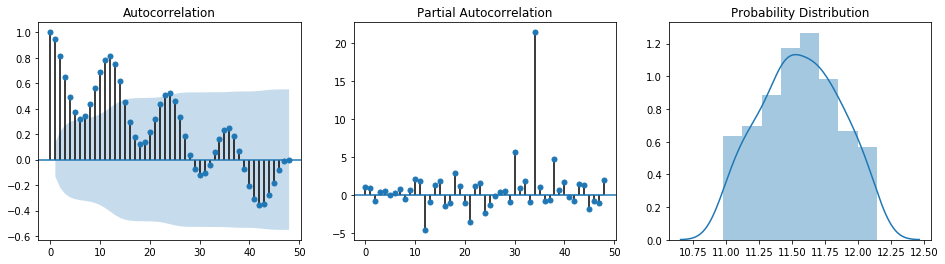

In [17]:
log_transformed_data = np.log(training_data)
plot_data_properties(log_transformed_data, 'Log tranformed training data')

In [18]:
test_stationarity(log_transformed_data)

Time series data is not stationary. Adfuller test pvalue=0.22522944188413385


Differencing is a basic operation or data transformation. It is the difference between y at time=t and y at time=t-x.
diff_1 =  y_t - y_t-1
Differencing makes the data stationary as it removes time series components from the data and you are left with residuals.
Notice, first order differencing took away only Trend not Seasonality. 

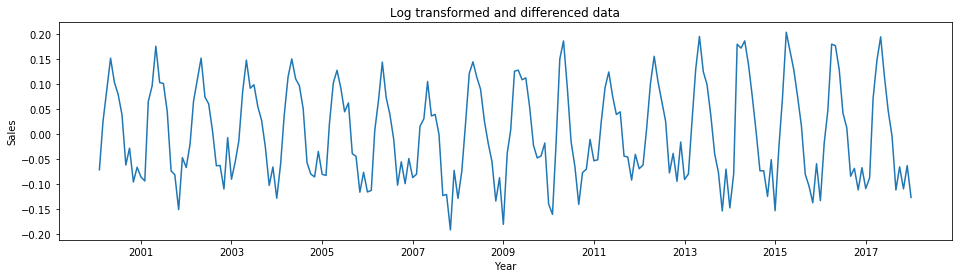

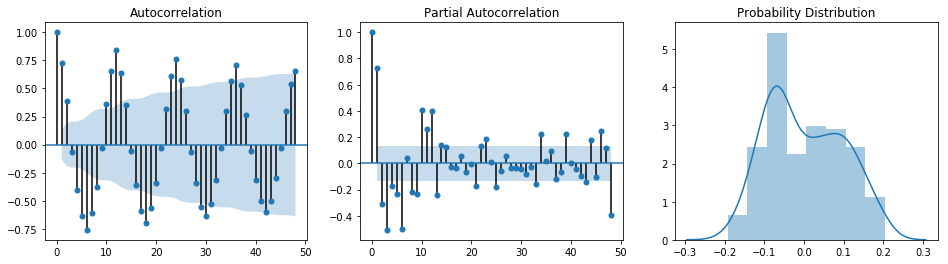

In [19]:
logged_diffed_data = log_transformed_data.diff()[1:]
plot_data_properties(logged_diffed_data, 'Log transformed and differenced data')

In [20]:
test_stationarity(logged_diffed_data)

Time series data is not stationary. Adfuller test pvalue=0.20533165780051377


We have to take 12th order difference to remove seasonality. You may ask how I decided to take 12th order difference not 6th or 8th or other order. We have discussed in seasonality section. Monthly data has seasonality at lag=12, weekly has at lag=4 and daily has at lag=30. However, you can also look at the ACF of log transformed data and see, serial correlation is very strong. 

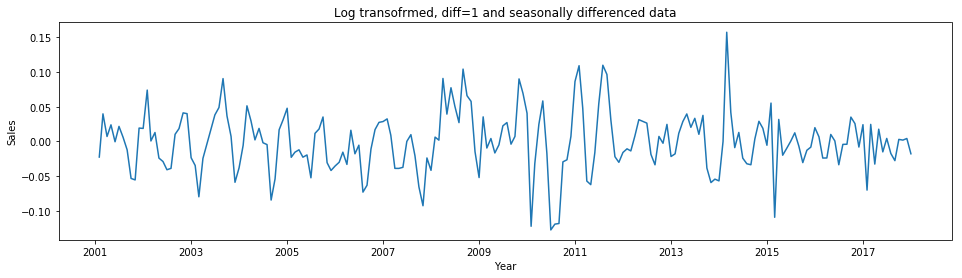

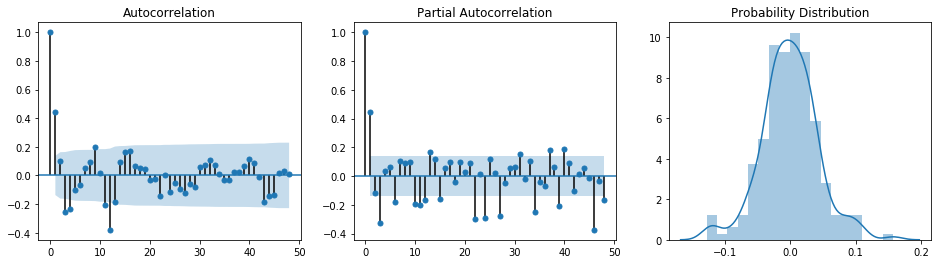

In [21]:
seasonally_diffed_data = logged_diffed_data.diff(12)[12:]
plot_data_properties(seasonally_diffed_data, 'Log transofrmed, diff=1 and seasonally differenced data')

Data is stationary now. If you look at the histogram of data it looks like Normal Distribution. I have used Shapiro normality test below to confirm that the data is normally distributed. It is one of the properties of stationary data. So, why differencing makes the data stationary? By differencing you only get the small changes of y between time steps. These changes usually are normally distributed with constant mean and variance, which is a charecteristic of stationary data.

In [22]:
test_stationarity(seasonally_diffed_data)

Time series data is stationary. Adfuller test pvalue=0.0006264163287311492


In [23]:
from scipy.stats import shapiro
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(np.round(p_value,3)))

In [24]:
shapiro_normality_test(seasonally_diffed_data.SPCS20RPSNSA)

Data failed shapiro normality test with p_value=0.005


# Model Fitting

As transformed data is stationary now we can proceed to model fitting phase. We had a brief chat about SARIMA before. I want to eloborate on this particular model. SARIMA, Seasonal ARIMA is a special member of ARIMA family which can model seasonal componenet of time series data. Just to recap what ARIMA means:
AR - Auto Regressive model means time series data is regressed on its lagged values. Lagged values become independent variables, whereas time series itself becomes the dependent variable. y = a_0 + a_1*y_t-1 + a_2*y_t-2, ....., a_k*y_t-k.
The main task here is to choose how many time steps to be used as independent variables. Please, do not let the word time series or lagged values to confuse you, they are just independent variables. In linear Regression, you could look at the correlation between independent and dependent variables and choose highly correlated variables as your features. Here you should do the same. But, you don't have to calculate correlation between lagged values and target variable, because you can use PACF to determine how many lags to use. PACF of stationary data has significant autocorrelation at lag=1 and the next autocorrelation at Lag=2 becomes insignificant. Ideally, AR order p should be 1. However, we will see in the model selection process that, we have to do parameter search on p to find the optimal value. However, initial guess will define on which values you should do grid search. In this case p = [0-2] would be sufficient.

I - order of integration: Basically, how many times you have differenced the data. We had it once d=1. Do not forget to fit the model to not differenced data when you set parameter d=1, as the algorithm will difference it. If you will fit on stationary data, that you dont need differencing anymore, d=0. We need differencing just to make the data stationary.

MA - Moving Average model: Time series is y regressed on resdiuals w. y = a_0 + a_1*w1 + a_2*w2 + .... + a_k*wk
Look at ACF plot to determine the order (q) of MA part of ARIMA model.ACF suggest order q=1 for MA part of the ARIMA model. However, we should do grid search to find an optimal model. I suggest to look at values q=[0-2]

Seasonal model - Seasonality has to be modelled together with AR and MA and it has 4 parameters (P,D,Q,s). 
Think of P, D and Q parameters being similar to AR, I and MA parameters, but only for seasonal componenet of the series. 
Choose P by looking at PACF and Q by looking at ACF. Number of seasonal differences have been taken is D. Frequency of seasonal effect is defined by s.
P = 1 - because we have significant correlation at lag=12, however they are not strong enough and we may not need to have an AR variable in the model. That's why we should grid search on P = [0-2]

D=1 - we difference for seasonality once

Q=1 - as we have strong correlation at lag=12 according to ACF plot. Let's perform grid search on parameter Q=[0-2], too.

s=12 - seasonality frequency, every 12 months

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

best_sarima_model function performs grid search on (p,d,q) and (P,D,Q,s) parameters and finds the best model taking statistical metrics AIC, BIC, HQIC as evaluation criteria. Lower AIC, BIC, HQIC means better model. These metrics reward goodness-of-fit (log-likelihood) and penalises overfitting. In our case having many lagged features leads to overfitting. AIC, BIC and HQIC balances the tradeoff between likelihood and degrees of freedom. You can see this property in their formula. I will not get into the details of other metrics, but will give an example below for supporting my point of using AIC:
AIC formula:
k is number of estimated parameters in the model, in other words number of features (lag terms). 
L is the maximum of the likelihood function.
AIC = 2k - 2ln(L)

I have seen many examples in industry, using only one of those metrics as a model selection criteria, but you may come across the cases where AIC of a model can be lower than another, while BIC is higher. That's why, try to choose a model over the other  if 2 of the 3 metrics are lower. 

In [26]:
def best_sarima_model(train_data,p,q,P,Q,d=1,D=1,s=12):
    best_model_aic = np.Inf 
    best_model_bic = np.Inf 
    best_model_hqic = np.Inf
    best_model_order = (0,0,0)
    models = []
    for p_ in p:
        for q_ in q:
            for P_ in P:
                for Q_ in Q:
                    try:
                        no_of_lower_metrics = 0
                        model = SARIMAX(endog=train_data,order=(p_,d,q_), seasonal_order=(P_,D,Q_,s),
                                        enforce_invertibility=False).fit()
                        models.append(model)
                        if model.aic <= best_model_aic: no_of_lower_metrics+=1
                        if model.bic <= best_model_bic: no_of_lower_metrics+=1
                        if model.hqic <= best_model_hqic:no_of_lower_metrics+=1
                        if no_of_lower_metrics >= 2:
                            best_model_aic = np.round(model.aic,0)
                            best_model_bic = np.round(model.bic,0)
                            best_model_hqic = np.round(model.hqic,0)
                            best_model_order = (p_,d,q_,P_,D,Q_,s)
                            current_best_model = model
                            models.append(model)
                            print("Best model so far: SARIMA" +  str(best_model_order) + 
                                  " AIC:{} BIC:{} HQIC:{}".format(best_model_aic,best_model_bic,best_model_hqic)+
                                  " resid:{}".format(np.round(np.exp(current_best_model.resid).mean(),3)))

                    except:
                        pass

    print('\n')
    print(current_best_model.summary())                
    return current_best_model, models  

Note, we are fitting model to log transformed data as we have set d=1 and D=1 parameters and the model will do the differencing for us. We evaluated SARIMA models with the parameters we have identified above. Summary below shows the best model or in other words lowest AIC, BIC, HQIC. The best model suggests that we don't need to have AR features, but only MA and seasonal MA feautres.

ARIMA or SARIMA models are OLS based models, that's why all OLS assumption are applicable to this family of models. I dont want to elaborate on these assumptions here. It is a topic of another article. However, we have to confirm that our model aligns with those assumptions. P values of coeefficients are <= 0.05. Residuals follow normal distribution, highly concentrated around 0. Residuals are stationary and homoscedastic. There is no serial correlation among residuls.

In [27]:
best_model, models = best_sarima_model(train_data=log_transformed_data,p=range(3),q=range(3),P=range(3),Q=range(3))

Best model so far: SARIMA(0, 1, 0, 0, 1, 0, 12) AIC:-701.0 BIC:-698.0 HQIC:-700.0 resid:352.481
Best model so far: SARIMA(0, 1, 0, 0, 1, 1, 12) AIC:-775.0 BIC:-769.0 HQIC:-773.0 resid:352.48
Best model so far: SARIMA(0, 1, 1, 0, 1, 1, 12) AIC:-810.0 BIC:-800.0 HQIC:-806.0 resid:352.48
Best model so far: SARIMA(0, 1, 1, 0, 1, 2, 12) AIC:-813.0 BIC:-800.0 HQIC:-808.0 resid:352.48
Best model so far: SARIMA(0, 1, 2, 0, 1, 1, 12) AIC:-846.0 BIC:-833.0 HQIC:-841.0 resid:352.48


                                 Statespace Model Results                                 
Dep. Variable:                       SPCS20RPSNSA   No. Observations:                  217
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 427.105
Date:                            Fri, 03 May 2019   AIC                           -846.209
Time:                                    16:21:18   BIC                           -832.937
Sample:                                01-01-2000   HQIC           

# Outlier 2000 and 2001 years

Text(0,0.5,'Residuals')

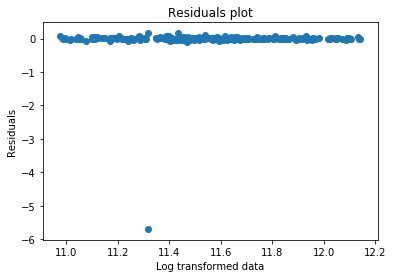

In [78]:
plt.scatter(x=log_transformed_data[1:], y=best_model.resid[1:]);
plt.title('Residuals plot')
plt.xlabel('Log transformed data')
plt.ylabel('Residuals')

In [58]:
shapiro_normality_test(best_model.resid[1:].drop(index= pd.datetime(2001, 1,1)))

Data failed shapiro normality test with p_value=0.0


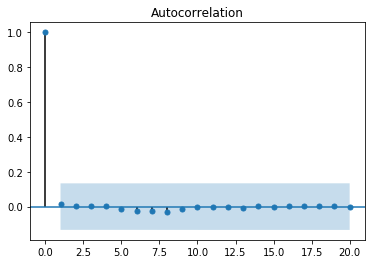

In [50]:
plot_acf(best_model.resid[1:], lags=20);

Now, it is turn to predict home sales from 2018-01-01 to 2019-01-01. I will use MAPE - mean absolute percentage error to see how well the model performs. Best model we have got is SARIMA(order=(0,1,2),seasonal_order=(0,1,1,12). I prefer MAPE error in time series analysis as it is more intuitive. Sklearn doesn't provide MAPE metric, that's why we have to code it ourselves. Formula:
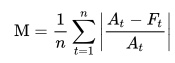


In [30]:
def mean_abs_pct_error(actual_values, forecast_values):
    err=0
    for i in range(len(forecast_values)):
        err += np.abs(actual_values.values[i] - forecast_values.values[i])/actual_values.values[i]
    return err[0] * 100/len(forecast_values)  

When you use predict function, there are some nuances to be careful about predict() function parameters:
1. type = 'levels' means to predicted values will be at the same level with endog/training values, in our case they were log transformed and not diffed at all. Then, if you notice I have np.exp() to scale the predicted values to original data. Remember, np.exp(np.log(a)) = a. So, np.exp(np.log(original data)) = original data
2. dynamice = True means to use the predicted value for time = t as a predictor for time = t+1.

In [31]:
preds_best=np.exp(best_model.predict(start=test_start_date,end='2019-01-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,preds_best),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,preds_best),2)))

MAPE:6.05%
MAE:7804.65


Plot the predicted values with original data and see the results. What can we infor from the below plot? 
Well a lot! The model can successfully capture the seasonal effect, however cannot do the same with trend. Home sales goes dowmward trend, however the model cannot capture it well. It knows that sales goes downward but due to seasonal effect, however there is a downward trend after 2018 which it struggles to predict. This is due to small training data we have got. If we had a larger data set, we could identify an economic cycle, and model it. Possibly, every 6-7 years housing sales follows a reduction.
Or if this downward trend continue in 2019 our 2020 prediction would definitely capture the trend.

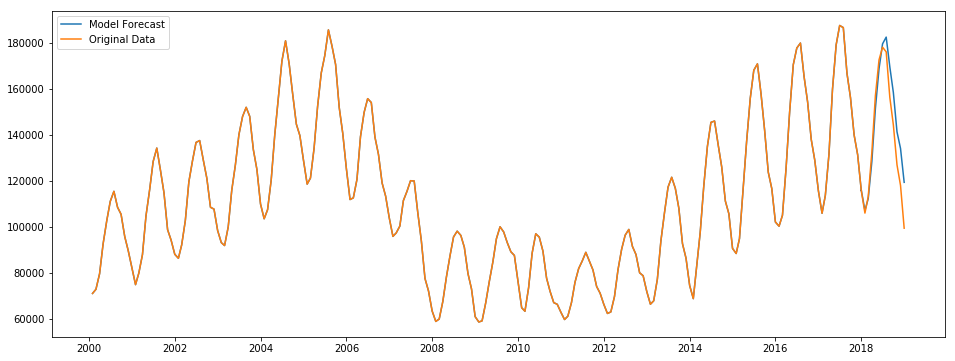

In [32]:
model_data = training_data.values[1:].reshape(216) - best_model.resid[1:]
model_data = pd.concat((model_data,preds_best))
plt.figure(figsize=(16,6));
plt.plot(model_data);
plt.plot(original_data[1:]);
plt.legend(['Model Forecast','Original Data']);

Another option to capture trend quicker is to add an AR term to the model. If we add 1 or 2 AR terms to the model it could react to the trend quicker and have less MAPE. The below plot is plotting MAPE for each model. Model performing better than best model in terms of test MAPE are in green.

In [33]:
tests_score = []
trains_score = []
models_order = []
models_aic = []
for model in models:
    if model.aic < -840:
        #model_order = (model.model_orders['ar'], model.model_orders['ma'],model.model_orders['seasonal_ar'],model.model_orders['seasonal_ma']/12)
        model_order = "ar:" + str(model.model_orders['ar']) + " ma:" + str(model.model_orders['ma']) + " s_ar:" + str(int(model.model_orders['seasonal_ar']/12)) + " s_ma:" + str(int(model.model_orders['seasonal_ma']/12))
        models_order.append(model_order)
        models_aic.append(model.aic)
        train_forecasts = training_data.values[1:].reshape(216) - model.resid[1:]
        train_mae = mean_absolute_error(training_data[1:], train_forecasts)
        trains_score.append(np.round(train_mae,3))
        preds=np.exp(model.predict(start=test_start_date, end='2019-01-01', dynamic=True, typ='levels'))    

        test_mape = mean_abs_pct_error(test_data,preds)
        tests_score.append(np.round(test_mape,3))
model_properties = {'aic':models_aic, 'model_order':models_order, 'train_score': trains_score, 'test_score':tests_score}    

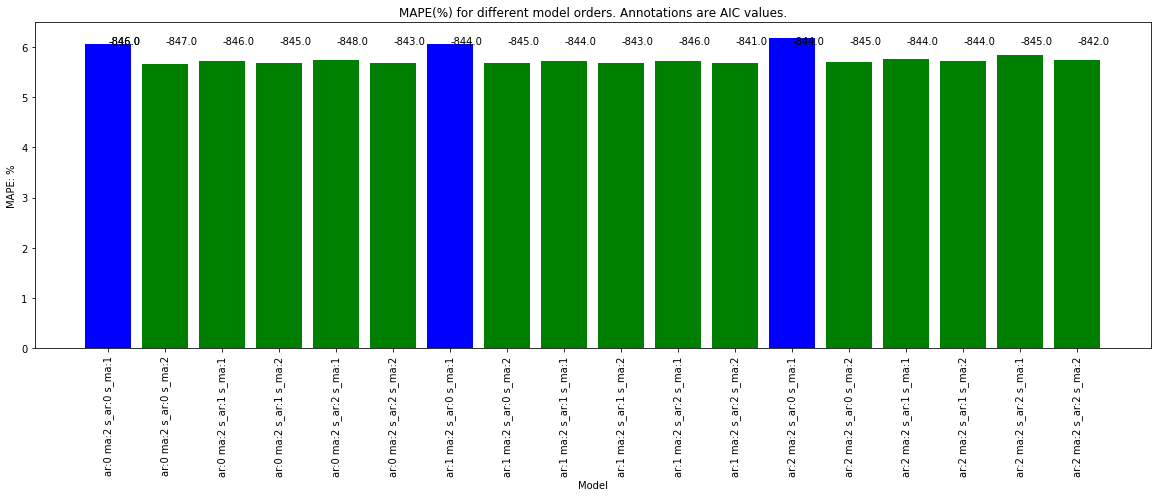

In [34]:
colors = ['g' if x < 6.05 else 'b' for x in model_properties['test_score']]
plt.figure(figsize=(20,6));
plt.bar(model_properties['model_order'],model_properties['test_score'], color= colors);
plt.xlabel('Model');
plt.ylabel('MAPE: %');
plt.title('MAPE(%) for different model orders. Annotations are AIC values.')
for i,aic in enumerate(model_properties['aic']):
    plt.annotate(np.round(aic,0), (model_properties['model_order'][i], model_properties['test_score'][1]));
plt.xticks(rotation=90);

We have added AR terms to the model and we have got improvement in test metrics. Test MAPE noe is 5.67%, improved from 6.05%, which is the test MAPE of the optimal model. However, if you look at AIC, BIC and HQIC we get higher values, which means probablty we are overfitting. We know that we have few data points around 300 and having 6 features in a linear model may lead to overfitting. If you take a look at P values of feature coefficients P value for ar.L1, ma.L2, ar.S.L12, ma.S.L12 and ma.S.L24 are higher than 0.05%.

In [35]:
agile_model = SARIMAX(endog=log_transformed_data,order=(1,1,2), seasonal_order=(1,1,2,12),
                                        enforce_invertibility=False).fit()
agile_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       SPCS20RPSNSA   No. Observations:                  217
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood                 428.640
Date:                            Fri, 03 May 2019   AIC                           -843.279
Time:                                    16:21:25   BIC                           -820.053
Sample:                                01-01-2000   HQIC                          -833.884
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0233      0.139     -0.167      0.867      -0.296       0.250
ma.L1          0.5440      0.113      4.818      0.000       0.323       0.765
ma.L2          0.4877      0.051      9.553      0.000       0.388       0.588
ar.S.L12      -0.4147      0.457     -0.907      0.365      -1.311       0.482
ma.S.L12      -0.3706      0.461     -0.803      0.422      -1.275       0.534
ma.S.L24      -0.4822      0.376     -1.281      0.200      -1.220       0.256
sigma2         0.0008   6.46e-05     12.338      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       58.59   Jarque-Bera (JB):               360.47
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                             1.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
agile_model_pred = np.exp(agile_model.predict(start=test_start_date,end='2019-01-01', dynamic=True, typ='levels'))
print("MAPE:{}%".format(np.round(mean_abs_pct_error(test_data,agile_model_pred),2)))
print("MAE:{}".format(np.round(mean_absolute_error(test_data,agile_model_pred),2)))

MAPE:5.67%
MAE:7311.8


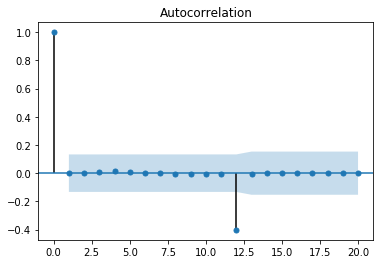

In [42]:
plot_acf(agile_model.resid, lags=20);